In [148]:
import torch

# Dataset

Crate the dataset : a random truth matrix $T : O\times A \to \{0,1\}$ 
- $O$ : number of objects
- $A$ : number of attributes for each object
This matrix represent for each object $o$ and each property $a$ if the object has the property or not.

In [149]:
# Size of object and properties set
O = 2
A = 2
shape = (O, A)

# Define the probability of obtaining 1s
prob = 0.5 

# Create a tensor filled with the probability value
prob_tensor = torch.full(shape, prob)

# Generate the tensor using the Bernoulli distribution
T = torch.bernoulli(prob_tensor)

# Simple RSA model

## Definition of the model

We begin by defining the parameters of our model :
- $\alpha$ : how much the speaker will be pragmatic
- $P$ : the prior probability of each object. If we already have information about the probability that the speaker will chose the object $o$ to describe.
- $C$ : the cost of each attribute. Typically the number of bits needed to transmit the attribute. 

In [150]:
alpha = torch.tensor(1) # By default, we set alpha to 1

We then define the literal listener. For now there is no cost in the model.

In [151]:
def literal_listener(T):
    L = torch.zeros(shape)
    sum = torch.sum(T)
    # We transpose the truth matrice : the listener is P(o|a) and not P(a|o)
    L = T.t()/sum
    # Sum along the rows to get the sum for each row
    row_sums = torch.sum(L, dim=1, keepdim=True)
    # Normalize each row by dividing by its sum
    L_normalized = L / row_sums
    return L_normalized 

Then the pragmatic speaker. The speaker will choose the object that maximizes the probability that the listener will understand the object.

In [152]:
def safelog(tensor, epsilon=1e-10):
    """
    Safely compute the logarithm of the tensor, replacing zeros with epsilon
    to avoid log(0) which would result in -inf.
    """
    # Ensure tensor is of float type to allow for log operations
    tensor = tensor.float()
    
    # Replace zeros with a small epsilon value to avoid log(0)
    safe_tensor = torch.where(tensor == 0, torch.tensor(epsilon, dtype=tensor.dtype), tensor)
    
    # Compute the logarithm
    log_tensor = torch.log(safe_tensor)
    
    return log_tensor

In [153]:
def pragmatic_speaker(T):
    S = torch.zeros(shape)
    L = literal_listener(T).t()
    sum = torch.sum(L)
    S = torch.exp(alpha*safelog(L))/sum
    # Sum along the rows to get the sum for each row
    row_sums = torch.sum(S, dim=1, keepdim=True)
    # Normalize each row by dividing by its sum
    S_normalized = S / row_sums
    return S_normalized

Finally the pragmatic listener.

In [154]:
def pragmatic_listener(T):
    L = pragmatic_speaker(T).t()
    row_sums = torch.sum(L, dim=1, keepdim=True)
    L_normalized = L / row_sums
    return L_normalized

The obtained matrice $L$ is the probability that the speaker is takling about the object $o$ given the attribute $a$.

$o$ is the row and $a$ is the column.

## use example

We are going to take a simple truth matrix $T$ :

In [155]:
T = torch.Tensor([[0,1],[1,1]])

In [156]:
print(T)

tensor([[0., 1.],
        [1., 1.]])


As values are chosen randomly it is possible than several objects have the same attributes. They are then not distinguishable. We thus are going to calculate the maximum performance of the model by counting the number of objects that are undistinguishable.

In [157]:
from collections import Counter
import numpy as np

# Convert to NumPy array
array = T.numpy()

# Convert rows to tuples for counting
rows_as_tuples = [tuple(row) for row in array]

# Count occurrences of each row
row_counts = Counter(rows_as_tuples)

# Identify non-unique rows
non_unique_rows = {row: count for row, count in row_counts.items() if count > 1}

# Results
num_non_unique_lines = len(non_unique_rows)
non_unique_lines_with_counts = non_unique_rows

print(f"Number of non-unique lines: {num_non_unique_lines}")
print("Non-unique lines with their counts:")
for row, count in non_unique_lines_with_counts.items():
    print(f"Row: {row}, Count: {count}")

Number of non-unique lines: 0
Non-unique lines with their counts:


In [158]:
max_perf = shape[0] - num_non_unique_lines
for _,count in non_unique_lines_with_counts.items():
    max_perf += 1/count
max_perf /= shape[0]
print(f"Maximal performance: {max_perf:.2f} of correct answers")

Maximal performance: 1.00 of correct answers


It is important to remember that this is the *theoretical* maximum performance. As soon as there is twice the same lines i.e two indishtinguishable objects, the model will be forced to randomly chose one object among those described by the attributes. This is the performance obtained when the model is run on an infinite number of guesses.

Now let's run the model

In [159]:
import pandas as pd

L0 = literal_listener(T)
S1 = pragmatic_speaker(T)
L1 = pragmatic_listener(T)

# Define the references
object_labels = ['o1', 'o2']
property_labels = ['p1', 'p2']

pd.options.display.float_format = '{:.1f}'.format


# Convert tensors to DataFrames with appropriate row and column labels
df_T = pd.DataFrame(T.numpy(), index=object_labels, columns=property_labels)
df_L0 = pd.DataFrame(L0.numpy(), index=property_labels, columns=object_labels)
df_S1 = pd.DataFrame(S1.numpy(), index=object_labels, columns=property_labels)
df_L1 = pd.DataFrame(L1.numpy(), index=property_labels, columns=object_labels)

# Display the DataFrames
display(df_T.rename_axis('T:', axis=1))
display(df_L0.rename_axis('Literal listener:', axis=1))
display(df_S1.rename_axis('Pragmatic speaker:', axis=1))
display(df_L1.rename_axis('Pragmatic listener:', axis=1))

T:,p1,p2
o1,0.0,1.0
o2,1.0,1.0


Literal listener:,o1,o2
p1,0.0,1.0
p2,0.5,0.5


Pragmatic speaker:,p1,p2
o1,0.0,1.0
o2,0.7,0.3


Pragmatic listener:,o1,o2
p1,0.0,1.0
p2,0.8,0.2


Now we can see what the model would do for a given object.
If the speaker wants to describe the object 1 ``o1``

In [160]:
chosen_property = torch.argmax(S1[0])
print(f"\nThe pragmatic speaker would choose property {property_labels[chosen_property]} to describe the object o1")

literal_guess = torch.argmax(L0[chosen_property])
pragmatic_guess = torch.argmax(L1[chosen_property])

print(f"Guess from the literal listener: {object_labels[literal_guess]} with a probability of {L0[chosen_property, literal_guess]:.2f}")
print(f"Guess from the pragmatic listener: {object_labels[pragmatic_guess]} with a probability of {L1[chosen_property, pragmatic_guess]:.2f}")


The pragmatic speaker would choose property p2 to describe the object o1
Guess from the literal listener: o1 with a probability of 0.50
Guess from the pragmatic listener: o1 with a probability of 0.75


Both listener have chosen the correct object but the pragmatic listener is more confident on its choice.

# RSA model with cost

We can add a cost function to the model. The cost function is a matrix $C$ of size $O\times A$ where $C[o,a]$ is the cost of the attribute $a$ for the object $o$. Intuitively, we can take as the cost the number of bits needed to transmit the attribute.

In [161]:
C = torch.ones(shape) # Here every attribute uses the same amount of bits

Now the speaker will take into account the cost of the attributes to choose the object to describe.

In [162]:
def pragmatic_speaker(T):
    S = torch.zeros(shape)
    L = literal_listener(T).t()
    sum = torch.sum(L)
    S = torch.exp(alpha*safelog(L) - C)/sum
    row_sums = torch.sum(S, dim=1, keepdim=True)
    S_normalized = S / row_sums
    return S_normalized

# RSA model with prior

We can also add prior knowledge of the probability distribution of the objects. For instance we may know that we are more likely to describe object 1 than object 2. We can add this information in the model by adding a prior matrix $P$ of size $O$ where $P[o]$ is the prior probability of the object $o$. 

This probability will be added in the litteral listener. For now we initialized the litteral listener with a uniform distribution as follows :
$$
L_\text{lit}(o|a) = \frac{T(o,a)}{\sum_{o'} T(o',a)}
$$
Now we can add the prior information in the litteral listener as follows :
$$
L_\text{lit}(o|a) = \frac{T(o,a)P[o]}{\sum_{o'} T(o',a)P[o']}
$$

In [163]:
def literal_listener(T,P=torch.ones(shape[0])):
    L = torch.zeros(shape)
    sum = torch.sum(T)
    # We transpose the truth matrice : the listener is P(o|a) and not P(a|o)
    L = ((T*P).t())/sum
    # Sum along the rows to get the sum for each row
    row_sums = torch.sum(L, dim=1, keepdim=True)
    # Normalize each row by dividing by its sum
    L_normalized = L / row_sums
    return L_normalized 

We can test this new function with the example below using the prior matrix $P = [0.25, 0.75]$.

In [164]:
P = torch.Tensor([0.25,0.75])
P = P.view(-1, 1)
L0_prior = literal_listener(T,P)

df_L0 = pd.DataFrame(L0.numpy(), index=property_labels, columns=object_labels)
display(df_L0.rename_axis('Literal listener:', axis=1))

df_L0_prior = pd.DataFrame(L0_prior.numpy(), index=property_labels, columns=object_labels)
display(df_L0_prior.rename_axis('Literal listener with prior knowledge:', axis=1))

Literal listener:,o1,o2
p1,0.0,1.0
p2,0.5,0.5


Literal listener with prior knowledge:,o1,o2
p1,0.0,1.0
p2,0.2,0.8


# RSA with recursivity

We saw that we used the litteral listener to calculate the pragmatic speaker. Then the pragmatic speaker to calculate the pragmatic listener. We can reiterate this process to get a better model : a model which is more pragmatic.

Let's build iterative functions ``pragmatic_listener`` and ``pragmatic_speaker`` which take as input a parameter ``k`` indicating the number of iterations.

Those functions will be methods of the class ``RSA``

In [165]:
class RSA:
    def __init__(self, T, alpha = 1, C=torch.ones(T.shape), P=torch.ones(shape[0]), k=1):
        self.T = T
        self.P = P
        self.C = C
        self.shape = T.shape
        self.alpha = alpha
        self.k = k
        self.L0 = torch.zeros(self.shape)
        self.SK = torch.zeros(self.shape)
        self.LK = torch.zeros(self.shape)
    
    def compute_matrices(self):

        def literal_listener():
            P = self.P.view(-1, 1)
            L = torch.zeros(self.shape)
            sum = torch.sum(self.T)
            L = ((self.T*P).t())/sum
            row_sums = torch.sum(L, dim=1, keepdim=True)
            L_normalized = L / row_sums
            return L_normalized 

        def pragmatic_speaker(LK_1):
            S = torch.zeros(self.shape)
            L = LK_1.t() # We use the listener of the previous level
            sum = torch.sum(L)
            S = torch.exp(self.alpha*safelog(L) - self.C)/sum
            row_sums = torch.sum(S, dim=1, keepdim=True)
            S_normalized = S / row_sums
            return S_normalized

        def pragmatic_listener(SK):
            L = torch.zeros(self.shape)
            L = SK.t()
            row_sums = torch.sum(L, dim=1, keepdim=True)
            L_normalized = L / row_sums
            return L_normalized
    
        self.L0 = literal_listener()
        self.LK = self.L0
        for i in range(self.k):
            self.SK = pragmatic_speaker(self.LK)
            self.LK = pragmatic_listener(self.SK)

    def display_matrices(self):
        # Define the references
        object_labels = ["o"+str(i+1) for i in range(self.shape[0])]
        property_labels = ["p"+str(i+1) for i in range(self.shape[1])]

        # Convert tensors to DataFrames with appropriate row and column labels
        df_T = pd.DataFrame(self.T.numpy(), index=object_labels, columns=property_labels)
        df_L0 = pd.DataFrame(self.L0.numpy(), index=property_labels, columns=object_labels)
        df_SK = pd.DataFrame(self.SK.numpy(), index=object_labels, columns=property_labels)
        df_LK = pd.DataFrame(self.LK.numpy(), index=property_labels, columns=object_labels)

        # Set float format
        pd.options.display.float_format = '{:.2f}'.format

        # Display the DataFrames inline with formatted floats
        print("T:")
        display(df_T.rename_axis('T:', axis=1))
        print("Literal listener:")
        display(df_L0.rename_axis('Literal listener:', axis=1))
        print("Pragmatic speaker:")
        display(df_SK.rename_axis('Pragmatic speaker:', axis=1))
        print("Pragmatic listener:")
        display(df_LK.rename_axis('Pragmatic listener:', axis=1))

    def describe_object(self, object_index):
        chosen_property = torch.argmax(self.S1[object_index])
        literal_guess = torch.argmax(self.L0[chosen_property])
        pragmatic_guess = torch.argmax(self.L1[chosen_property])

        print(f"\nThe pragmatic speaker would choose property p{chosen_property + 1} to describe the object o{object_index + 1}")
        print(f"Guess from the literal listener: o{literal_guess + 1} with a probability of {self.L0[chosen_property, literal_guess]:.4f}")
        print(f"Guess from the pragmatic listener: o{pragmatic_guess + 1} with a probability of {self.L1[chosen_property, pragmatic_guess]:.4f}")

We can test this new model with the example below using the prior matrix $P = [0.25, 0.75]$ and the cost matrix $C = \begin{bmatrix} 1 & 1  \\ 1 & 1  \end{bmatrix}$.

In [166]:
T = torch.Tensor([[0,1],[1,1]])
shape = T.shape
P = torch.Tensor([0.25,0.75])
k=1
C = torch.ones(shape)

In [167]:
rsa = RSA(T, alpha=1, C=C, P=P, k=3)

In [168]:
rsa.compute_matrices()
rsa.display_matrices()

T:


T:,p1,p2
o1,0.00,1.00
o2,1.00,1.00


Literal listener:


Literal listener:,o1,o2
p1,0.00,1.00
p2,0.25,0.75


Pragmatic speaker:


Pragmatic speaker:,p1,p2
o1,0.00,1.00
o2,0.84,0.16


Pragmatic listener:


Pragmatic listener:,o1,o2
p1,0.00,1.00
p2,0.86,0.14


Ainsi on peut voir que le modèle est plus confiant dans ses choix lorsque ``k`` augmente. Nous pouvons représenter l'évolution de l'écart-type des probabilités pour chaque objet en fonction de ``k``.

In [169]:
import matplotlib.pyplot as plt

def plot_std_evolution(T, max_k=10):
    std_devs = []

    for k in range(1, max_k + 1):
        rsa = RSA(T, k=k)
        rsa.compute_matrices()
        std_dev = torch.std(rsa.LK, dim=1).mean().item()
        std_devs.append(std_dev)

    plt.plot(range(1, max_k + 1), std_devs, marker='o')
    plt.xlabel('k')
    plt.ylabel('Mean Standard Deviation of Probabilities')
    plt.title('Evolution of Standard Deviation of Probabilities with Increasing k')
    plt.grid(True)
    plt.show()

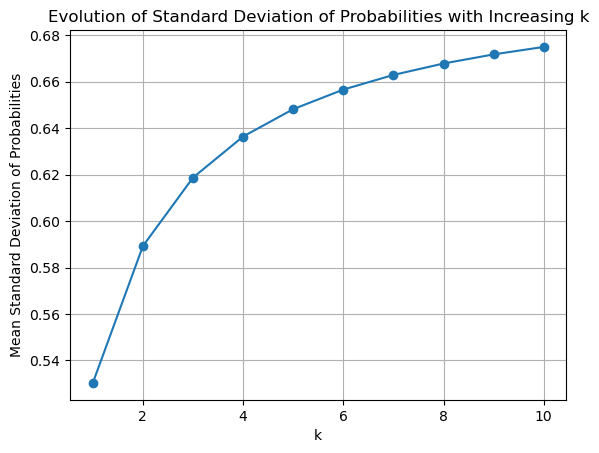

In [170]:
T = torch.tensor([[0., 1.], [1., 1.]])
plot_std_evolution(T, max_k=10)